In [1]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Data Fetching

In [2]:
data_df = pd.read_csv("./data/input/train.csv")
data_df.head()

,uuid,title,author,abstract,Keywords,label
0,0,Accessible Visual Artworks for Blind and Visua...,"Quero, Luis Cavazos; Bartolome, Jorge Iranzo; ...",Despite the use of tactile graphics and audio ...,accessibility technology; multimodal interacti...,0
1,1,Seizure Detection and Prediction by Parallel M...,"Li, Chenqi; Lammie, Corey; Dong, Xuening; Amir...","During the past two decades, epileptic seizure...",CNN; Seizure Detection; Seizure Prediction; EE...,1
2,2,Fast ScanNet: Fast and Dense Analysis of Multi...,"Lin, Huangjing; Chen, Hao; Graham, Simon; Dou,...",Lymph node metastasis is one of the most impor...,Histopathology image analysis; computational p...,1
3,3,Long-Term Effectiveness of Antiretroviral Ther...,"Huang, Peng; Tan, Jingguang; Ma, Wenzhe; Zheng...",In order to assess the effectiveness of the Ch...,HIV; ART; mortality; observational cohort stud...,0
4,4,Real-Time Facial Affective Computing on Mobile...,"Guo, Yuanyuan; Xia, Yifan; Wang, Jing; Yu, Hui...",Convolutional Neural Networks (CNNs) have beco...,facial affective computing; convolutional neur...,0


In [3]:
data_df.drop(columns=['uuid', 'title', 'author', 'Keywords'], inplace=True, axis=1)
print(data_df.shape)

(6000, 2)


# Data Cleaning & Transformation

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [7]:
import re
import numpy as np

do_remove_punct = True
do_lemmatize = True
do_lowercase = True
do_remove_stop = True
do_remove_nums = True

def custom_tokenize(row):
    text = row['abstract']
    
    # 01 - Punctuations
    if do_remove_punct:
        text = re.sub(r'([^\w\s])', ' ', text)

    # 02 - Lemmatization
    if do_lemmatize:
        tokens_list = nltk.word_tokenize(text)
        text = ' '.join([lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in tokens_list])

    # 03 - Lowercasing
    if do_lowercase:
        text = text.lower()

    # 04 - Removing stop words (i.e. grammar defining words, not adding value to main topic)
    if do_remove_stop:
        text = ' '.join([t for t in text.split() if t not in stopwords])

    # 05 - Removing numbers
    if do_remove_nums:
        text = re.sub(r'\b[0-9]+\b', ' ', text)

    # Removing redundant spaces
    text = re.sub(r' +', ' ', text)

    row['custom_tokenized'] = text.split()
    return row

data_df['custom_tokenized'] = [list() for _ in range(data_df.shape[0])]
data_df = data_df.apply(custom_tokenize, axis=1)

data_df.head(20)

,abstract,label,custom_tokenized
0,Despite the use of tactile graphics and audio ...,0,"[despite, use, tactile, graphic, audio, guide,..."
1,"During the past two decades, epileptic seizure...",1,"[past, two, decade, epileptic, seizure, detect..."
2,Lymph node metastasis is one of the most impor...,1,"[lymph, node, metastasis, one, important, indi..."
3,In order to assess the effectiveness of the Ch...,0,"[order, ass, effectiveness, chinese, governmen..."
4,Convolutional Neural Networks (CNNs) have beco...,0,"[convolutional, neural, networks, cnns, become..."
5,Previously we showed the generation of a prote...,1,"[previously, show, generation, protein, trap, ..."
6,Facial emotion recognition (FER) is a field of...,0,"[facial, emotion, recognition, fer, field, res..."
7,This paper proposes a machine learning model b...,0,"[paper, proposes, machine, learn, model, base,..."
8,Most current state-of-the-art blind image qual...,0,"[current, state, art, blind, image, quality, a..."
9,Surgical workflow recognition has numerous pot...,1,"[surgical, workflow, recognition, numerous, po..."


# Data Split - Training & Validation

In [8]:
from sklearn.model_selection import train_test_split

X = data_df[['abstract', 'custom_tokenized']]
Y = data_df[['label']]

X_train_text, X_val_text, Y_train, Y_val = train_test_split(X, 
                                                            Y, 
                                                            test_size=0.2, 
                                                            shuffle=True, 
                                                            random_state=42
                                                           )
del X, Y

In [9]:
corpus_docs_train = X_train_text['custom_tokenized'].tolist()
corpus_docs_val = X_val_text['custom_tokenized'].tolist()

In [18]:
corpus_docs_train_1 = [' '.join([token for token in tokenized_doc]) for tokenized_doc in corpus_docs_train]
corpus_docs_val_1 = [' '.join([token for token in tokenized_doc]) for tokenized_doc in corpus_docs_val]

In [20]:
corpus_docs_train_1[0]

'image partition important preprocessing step many state art algorithm use perform high level computer vision task typically partition conduct without regard task hand propose task specific image partition framework produce region base image representation lead high task performance reach use task oblivious partition framework exist supervise partition framework albeit number propose method partition image mean correlation cluster maximize linear discriminant function define superpixel graph parameter discriminant function define task specific similarity dissimilarity among superpixels estimate base structure support vector machine svm use task specific training data svm learn lead well generalization ability construction superpixel graph use define discriminant function allows rich set feature incorporate improve discriminability robustness evaluate learn task aware partition algorithm three benchmark datasets results show task aware partition lead well label performance partition com

In [21]:
corpus_docs_val_1[0]

'colonoscopy tool choice prevent colorectal cancer detect remove polyp become cancerous however colonoscopy hamper fact endoscopists routinely miss polyp miss polyp appear endoscopist field view others miss simply substandard coverage procedure e colon see paper attempt rectify problem substandard coverage colonoscopy introduction c2d2 colonoscopy coverage deficiency via depth algorithm detects deficient coverage thereby alert endoscopist revisit give area specifically c2d2 consists two separate algorithm first performs depth estimation colon give ordinary rgb video stream second computes coverage give depth estimate rather compute coverage entire colon algorithm computes coverage locally segment segment basis c2d2 indicate real time whether particular area colon suffer deficient coverage endoscopist return area coverage algorithm first algorithm evaluate large scale way depth estimation technique first calibration free unsupervised method apply colonoscopy c2d2 algorithm achieves stat

# Vectorization

#### Instantiating vectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(1,1),
                                   min_df=20,          # Features should occur in minimum this much number of documents
                                   max_df=0.8          # Features should occur in at the max this much proportion of documents
                                  )

In [23]:
tfidf_vectorizer

TfidfVectorizer(max_df=0.8, min_df=20)

#### Fitting the vectorizer on Train data
#### And transforming the Train data

In [25]:
tfidf_matrix_train = tfidf_vectorizer.fit_transform(corpus_docs_train_1)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

#### Transforming the Validation data
#### Never fit on Validation or Test data! :)

In [26]:
tfidf_matrix_val = tfidf_vectorizer.transform(corpus_docs_val_1)

### How does it look like?

In [27]:
tfidf_matrix_train

<4800x2881 sparse matrix of type '<class 'numpy.float64'>'
	with 328360 stored elements in Compressed Sparse Row format>

In [28]:
tfidf_matrix_train[0]

<1x2881 sparse matrix of type '<class 'numpy.float64'>'
	with 82 stored elements in Compressed Sparse Row format>

# Model Training

### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(tfidf_matrix_train, Y_train)
Y_pred = logreg.predict(tfidf_matrix_val)

C:\Users\suket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
from sklearn.metrics import accuracy_score, f1_score

print('Validation accuracy %s' % accuracy_score(Y_val, Y_pred))
print('Validation F1 score: {}'.format(f1_score(Y_val, Y_pred, average='weighted')))

Validation accuracy 0.9575
Validation F1 score: 0.9575014462297675


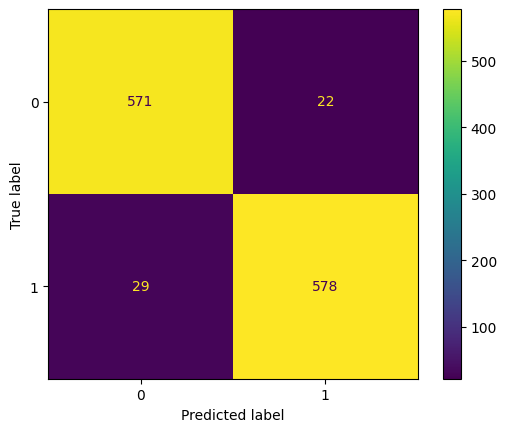

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_val, Y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

### Cross Validation Strategy

In [39]:
from scipy.sparse import vstack
from sklearn.model_selection import cross_validate

# Coagulate train and test data to one single data
# Infact this should not be needed if the above training process was not done :)
X = vstack([tfidf_matrix_train, tfidf_matrix_val])
y = Y_train['label'].tolist() + Y_val['label'].tolist()

cv_results = cross_validate(logreg, X, y, cv=5)

In [40]:
cv_results

{'fit_time': array([0.04799771, 0.04639435, 0.06246328, 0.05562401, 0.15072489]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([0.9525    , 0.96083333, 0.95416667, 0.95666667, 0.95916667])}